## 1. Initialise the environment

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"
from torchvision import datasets, transforms

# Common imports
import numpy as np
import os, time
import pandas as pd

# Deep Learning imports
import tensorflow as tf
import keras

# To plot nice figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rc('figure', dpi=100)
import seaborn as sns; sns.set()

# Check the versions are OK (both should be 2 or more)
print(tf.__version__)
print(keras.__version__)

2.13.0
2.13.1


## 2. Loading, investigating, manipulating and displaying data

Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)


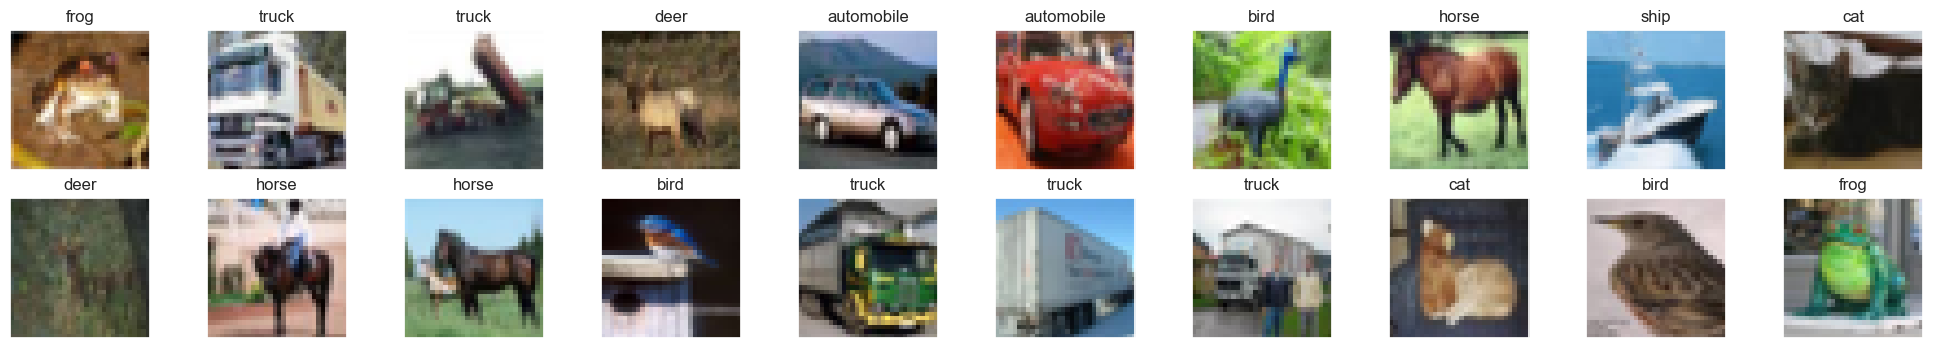

In [2]:
from keras.datasets import cifar10
# load dataset
(trainX, trainy), (testX, testy) = cifar10.load_data()
# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']
trainy = trainy.flatten()
testy = testy.flatten()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(trainX[idx])
    ax.set_title(classes[trainy[idx]])

(trainX, trainy), (testX, testy) = cifar10.load_data()
# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))



In [3]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
# load train and test dataset
def load_dataset():
 # load dataset
 (trainX, trainY), (testX, testY) = cifar10.load_data()
 trainX, valX, trainY, valY = train_test_split(
trainX, trainY, test_size=0.25, random_state=42)
 # one hot encode target values

 trainY = to_categorical(trainY)
 valY = to_categorical(valY)
 testY = to_categorical(testY)
 
 return trainX, trainY, testX, testY, valX, valY
 
# scale pixels
def prep_pixels(train, test, val):
 # convert from integers to floats
 train_norm = train.astype('float32')
 test_norm = test.astype('float32')
 val_norm = val.astype('float32')
 # normalize to range 0-1
 train_norm = train_norm / 255.0
 test_norm = test_norm / 255.0
 val_norm = val_norm / 255.0
 # return normalized images
 return train_norm, test_norm, val_norm

## 3. Initial model successfully trained (and acting as a baseline)

### 3.1. Baseline CNN model 

In [4]:
trainX, trainY, testX, testY, valX, valY = load_dataset()
# prepare pixel data
trainX, testX, valX = prep_pixels(trainX, testX, valX)

In [5]:
def predict_result(type_dataset, model):

    data, labels = (valX, valY) if type_dataset == 'validation' else (testX, testY)

    prediction = np.argmax(model.predict(data), axis=1)
    labels = np.argmax(labels, axis=1)
    
    preds = [classes[pred] for pred in prediction]
    actuals = [classes[actual] for actual in labels]
    
    
    return actuals, preds

In [6]:
def plot_final_accuracy(model, type_dataset='validation'):

    actuals, preds = predict_result(type_dataset, model)

    df = pd.DataFrame({'actual': actuals, 'pred': preds})

    df['correct'] = df['actual'] == df['pred']
    df['correct'] = df['correct'].astype(int)

    df_group = df.groupby(['actual', 'pred']).sum()
    df_group = df_group.reset_index()

    df_group = df_group[df_group['actual'] == df_group['pred']]

    actual_counts = df.groupby('actual').count()['pred'].to_numpy()
    df_group['count'] = actual_counts

    
    df_group['accuracy'] = df_group['correct'] / df_group['count']

    print(df_group)
    # Create a bar plot using matplotlib
    # plt.bar(df_group['actual'], df_group['accuracy'])
    fig, ax = plt.subplots()
    ax.bar(df_group['actual'], df_group['accuracy'])

    plt.xticks(rotation=30,  ha='right')
    plt.xlabel('Actual')
    plt.ylabel('Accuracy')
    plt.title('Accuracy')
    plt.show()

In [7]:
def plot_history(history,y=1):
    # Plot the results (shifting validation curves appropriately)
    plt.figure(figsize=(8,5))
    n = len(history.history['accuracy'])
    plt.plot(np.arange(0,n),history.history['accuracy'], color='orange')
    plt.plot(np.arange(0,n),history.history['loss'],'b')
    plt.plot(np.arange(0,n)+0.5,history.history['val_accuracy'],'r') 
    plt.plot(np.arange(0,n)+0.5,history.history['val_loss'],'g')
    plt.legend(['Train Acc','Train Loss','Val Acc','Val Loss'])
    plt.grid(True)
    plt.gca().set_ylim(0, y)  
    plt.show() 

In [8]:
def model_cnn():
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(keras.layers.Dense(10, activation='softmax'))
    model.compile(loss ='categorical_crossentropy', optimizer ='adam', metrics =['accuracy'])
    # compile model
    
    return model

In [9]:
# Custom learning schedules function
def  lrfn(epoch):
    LR_START = 1e-5
    LR_MAX = 1e-3
    LR_RAMPUP_EPOCHS = 5
    LR_SUSTAIN_EPOCHS = 0
    LR_STEP_DECAY = 0.75

    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = LR_MAX * LR_STEP_DECAY**((epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS)//2)
    return lr

In [10]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras.callbacks import EarlyStopping

early_stopping_cb = EarlyStopping(monitor='val_accuracy', 
                                patience=10,
                                min_delta=1e-5,
                                verbose=1, 
                                mode='auto', 
                                restore_best_weights=True)

def do_all(data_agumentation = False):
    # define model
    model = model_cnn()

    callbacks = [early_stopping_cb]
    
    if data_agumentation:
        angumentation = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1)
        
        # Applying learning rate scheduler
        lr_sch = LearningRateScheduler(lrfn)
        callbacks.append(lr_sch)
        
        training_dt_input = angumentation.flow(trainX, trainY)
        validation_dt_input = angumentation.flow(valX, valY)
        history = model.fit(
            training_dt_input,
            epochs=20, 
            batch_size=64,
            callbacks=callbacks,
            validation_data=validation_dt_input
        )
    history = model.fit(trainX, trainY,epochs=20, batch_size=64, callbacks=callbacks, 
                       verbose=1,validation_data=(valX,valY))
    
    max_val_acc = np.max(history.history['val_accuracy'])
    return (max_val_acc, history, model)

In [11]:
valacc, history, model = do_all()

Epoch 1/20
586/586 [==============================] - 103s 173ms/step - loss: 1.5238 - accuracy: 0.4435 - val_loss: 1.2548 - val_accuracy: 0.5481
Epoch 2/20
586/586 [==============================] - 106s 180ms/step - loss: 1.0530 - accuracy: 0.6271 - val_loss: 0.9517 - val_accuracy: 0.6617
Epoch 3/20
586/586 [==============================] - 107s 183ms/step - loss: 0.8202 - accuracy: 0.7123 - val_loss: 0.8836 - val_accuracy: 0.6909
Epoch 4/20
586/586 [==============================] - 108s 185ms/step - loss: 0.6759 - accuracy: 0.7629 - val_loss: 0.7783 - val_accuracy: 0.7382
Epoch 5/20
586/586 [==============================] - 107s 183ms/step - loss: 0.5431 - accuracy: 0.8089 - val_loss: 0.8006 - val_accuracy: 0.7361
Epoch 6/20
586/586 [==============================] - 110s 187ms/step - loss: 0.4239 - accuracy: 0.8508 - val_loss: 0.8057 - val_accuracy: 0.7451
Epoch 7/20
586/586 [==============================] - 108s 184ms/step - loss: 0.3361 - accuracy: 0.8806 - val_loss: 0.8500 -

Max validation accuracy 75.104


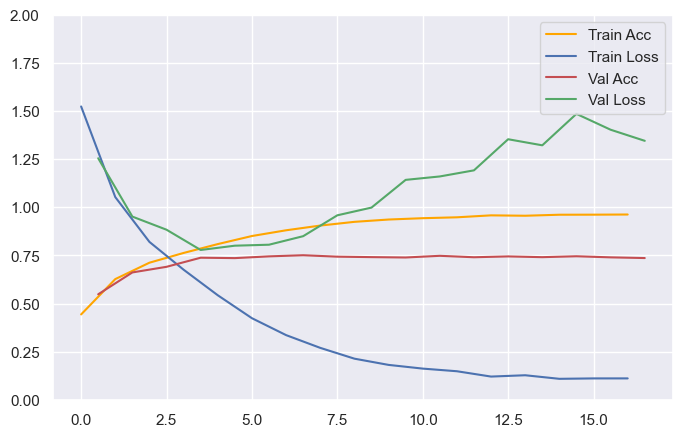

In [12]:
print('Max validation accuracy %.3f' % (valacc * 100.0))
plot_history(history, 2.0)

391/391 [==============================] - 9s 23ms/step
        actual        pred  correct  count  accuracy
0     airplane    airplane      973   1235  0.787854
11  automobile  automobile     1059   1212  0.873762
22        bird        bird      917   1270  0.722047
33         cat         cat      717   1291  0.555383
44        deer        deer      793   1182  0.670897
55         dog         dog      795   1263  0.629454
66        frog        frog      934   1219  0.766202
77       horse       horse     1016   1259  0.806990
88        ship        ship     1112   1280  0.868750
99       truck       truck     1072   1289  0.831652


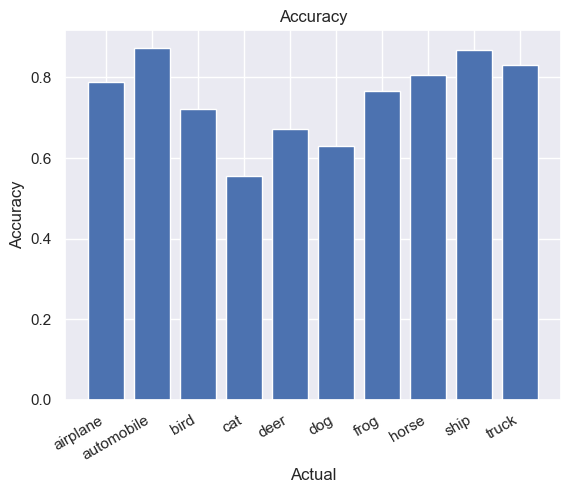

In [13]:
plot_final_accuracy(model)


# 4. Optimization


## 4.1 Dropout 0.2

In [14]:
def model_cnn():
	model = keras.models.Sequential()
	model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
	model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(keras.layers.MaxPooling2D((2, 2)))
	model.add(keras.layers.Dropout(0.2))
	model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(keras.layers.MaxPooling2D((2, 2)))
	model.add(keras.layers.Dropout(0.2))
	model.add(keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(keras.layers.MaxPooling2D((2, 2)))
	model.add(keras.layers.Dropout(0.2))
	model.add(keras.layers.Flatten())
	model.add(keras.layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(keras.layers.Dropout(0.2))
	model.add(keras.layers.Dense(10, activation='softmax'))
	model.compile(loss ='categorical_crossentropy', optimizer ='adam', metrics =['accuracy'])
    # compile model
	return model

In [15]:
valacc, history, model = do_all()

Epoch 1/20
586/586 [==============================] - 111s 186ms/step - loss: 1.7313 - accuracy: 0.3598 - val_loss: 1.3796 - val_accuracy: 0.4893
Epoch 2/20
586/586 [==============================] - 116s 198ms/step - loss: 1.3002 - accuracy: 0.5300 - val_loss: 1.1322 - val_accuracy: 0.5997
Epoch 3/20
586/586 [==============================] - 114s 194ms/step - loss: 1.0670 - accuracy: 0.6241 - val_loss: 0.8980 - val_accuracy: 0.6787
Epoch 4/20
586/586 [==============================] - 112s 192ms/step - loss: 0.9320 - accuracy: 0.6706 - val_loss: 0.8362 - val_accuracy: 0.7042
Epoch 5/20
586/586 [==============================] - 103s 175ms/step - loss: 0.8264 - accuracy: 0.7098 - val_loss: 0.8960 - val_accuracy: 0.6967
Epoch 6/20
586/586 [==============================] - 101s 173ms/step - loss: 0.7648 - accuracy: 0.7316 - val_loss: 0.7090 - val_accuracy: 0.7518
Epoch 7/20
586/586 [==============================] - 108s 184ms/step - loss: 0.7028 - accuracy: 0.7519 - val_loss: 0.6742 -

Max validation accuracy 80.688


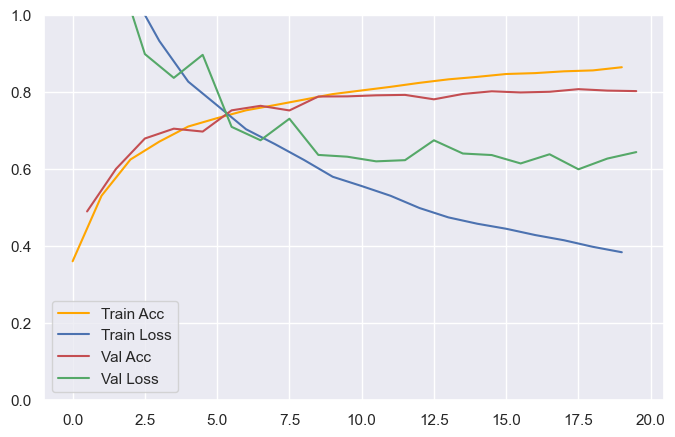

In [16]:
print('Max validation accuracy %.3f' % (valacc * 100.0))
plot_history(history, 1.0)

391/391 [==============================] - 10s 24ms/step
        actual        pred  correct  count  accuracy
0     airplane    airplane     1017   1235  0.823482
11  automobile  automobile     1120   1212  0.924092
22        bird        bird      884   1270  0.696063
33         cat         cat      813   1291  0.629744
44        deer        deer      898   1182  0.759729
55         dog         dog      881   1263  0.697546
66        frog        frog     1024   1219  0.840033
77       horse       horse     1113   1259  0.884035
88        ship        ship     1142   1280  0.892188
99       truck       truck     1131   1289  0.877424


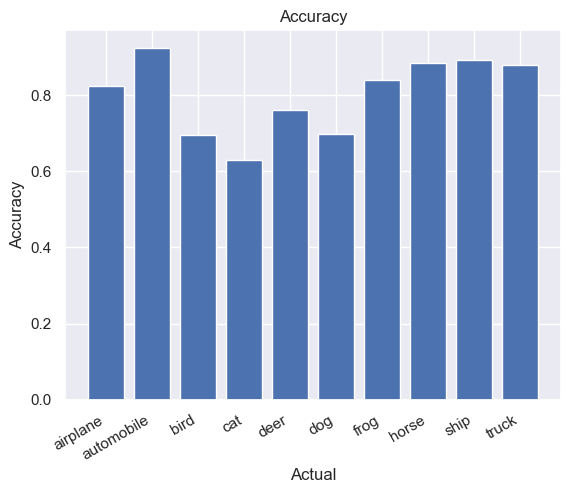

In [17]:
plot_final_accuracy(model)

## 4.2. Data Augmentation

In [18]:
valacc, history, model = do_all(True)

Epoch 1/20
1172/1172 [==============================] - 144s 121ms/step - loss: 2.2920 - accuracy: 0.1446 - val_loss: 2.1462 - val_accuracy: 0.2286 - lr: 1.0000e-05
Epoch 2/20
1172/1172 [==============================] - 140s 120ms/step - loss: 1.7785 - accuracy: 0.3397 - val_loss: 1.5020 - val_accuracy: 0.4458 - lr: 2.0800e-04
Epoch 3/20
1172/1172 [==============================] - 144s 123ms/step - loss: 1.4863 - accuracy: 0.4579 - val_loss: 1.3637 - val_accuracy: 0.5107 - lr: 4.0600e-04
Epoch 4/20
1172/1172 [==============================] - 144s 123ms/step - loss: 1.3002 - accuracy: 0.5342 - val_loss: 1.1305 - val_accuracy: 0.6033 - lr: 6.0400e-04
Epoch 5/20
1172/1172 [==============================] - 139s 119ms/step - loss: 1.1512 - accuracy: 0.5908 - val_loss: 1.0722 - val_accuracy: 0.6182 - lr: 8.0200e-04
Epoch 6/20
1172/1172 [==============================] - 140s 120ms/step - loss: 1.0552 - accuracy: 0.6280 - val_loss: 0.9169 - val_accuracy: 0.6756 - lr: 0.0010
Epoch 7/20
117

Max validation accuracy 83.800


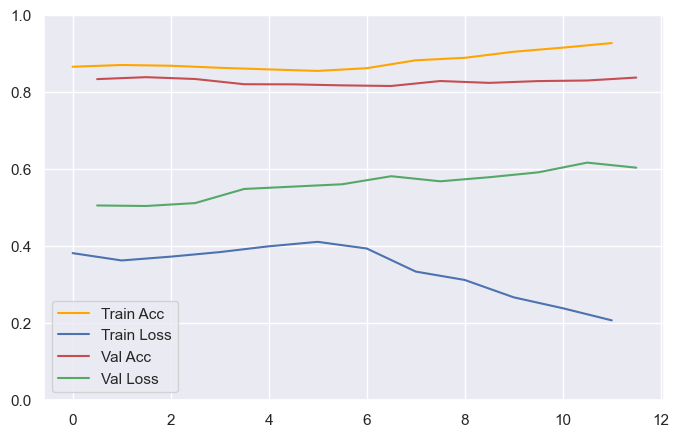

In [19]:
print('Max validation accuracy %.3f' % (valacc * 100.0))
plot_history(history, 1.0)

391/391 [==============================] - 9s 24ms/step
        actual        pred  correct  count  accuracy
0     airplane    airplane     1039   1235  0.841296
11  automobile  automobile     1122   1212  0.925743
21        bird        bird      932   1270  0.733858
32         cat         cat      897   1291  0.694810
42        deer        deer     1028   1182  0.869712
52         dog         dog      932   1263  0.737926
63        frog        frog     1092   1219  0.895816
73       horse       horse     1063   1259  0.844321
84        ship        ship     1213   1280  0.947656
95       truck       truck     1157   1289  0.897595


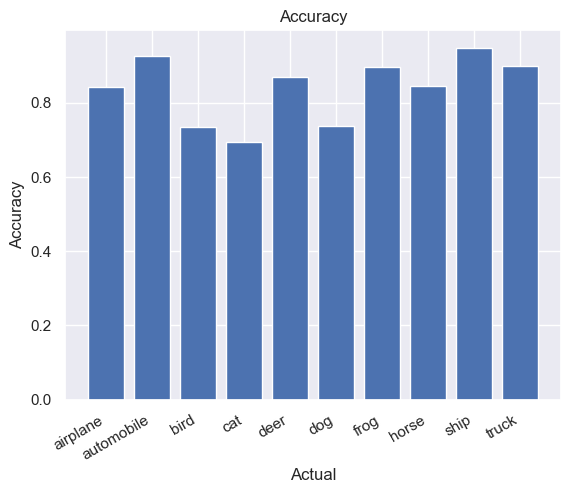

In [20]:
plot_final_accuracy(model)

 ## 5.Selection of the best and applying to test set

In [21]:
print((testX.shape, testY.shape))
model.evaluate(testX,testY)

((10000, 32, 32, 3), (10000, 10))
313/313 [==============================] - 8s 24ms/step - loss: 0.4991 - accuracy: 0.8339


[0.4991491138935089, 0.833899974822998]

313/313 [==============================] - 7s 24ms/step
        actual        pred  correct  count  accuracy
0     airplane    airplane      841   1000     0.841
10  automobile  automobile      943   1000     0.943
19        bird        bird      724   1000     0.724
30         cat         cat      673   1000     0.673
41        deer        deer      860   1000     0.860
51         dog         dog      730   1000     0.730
62        frog        frog      897   1000     0.897
71       horse       horse      845   1000     0.845
82        ship        ship      931   1000     0.931
93       truck       truck      895   1000     0.895


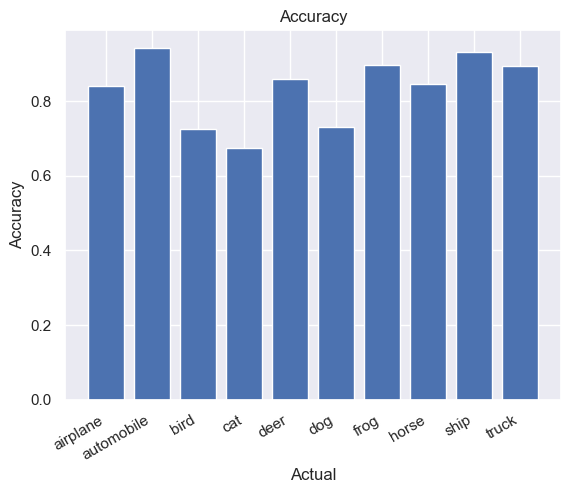

In [23]:
plot_final_accuracy(model,"test")

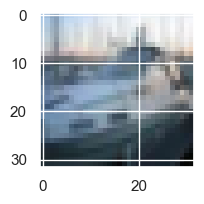

1/1 [==============================] - 0s 33ms/step
ship


In [22]:
fig = plt.figure(figsize=(25, 2))
plt.imshow(testX[2], cmap = plt.cm.binary)
plt.show()

result = model.predict(testX[2].reshape(1, 32, 32, 3))
print(classes[result.argmax()])
